# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import pdb

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0, encoding='latin-1')
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = (measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})
                    .drop('AGE', axis=1))

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

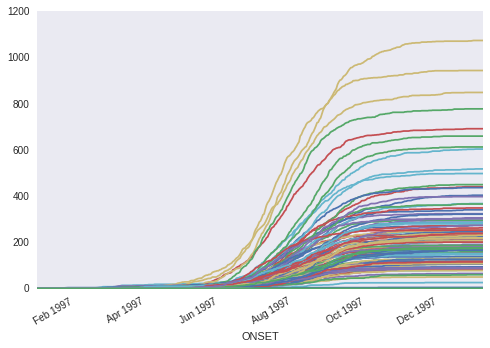

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [9]:
total_district_cases = measles_onset_dist.sum()

Top 5 districts by number of cases

In [10]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

Age distribution of cases, by confirmation status

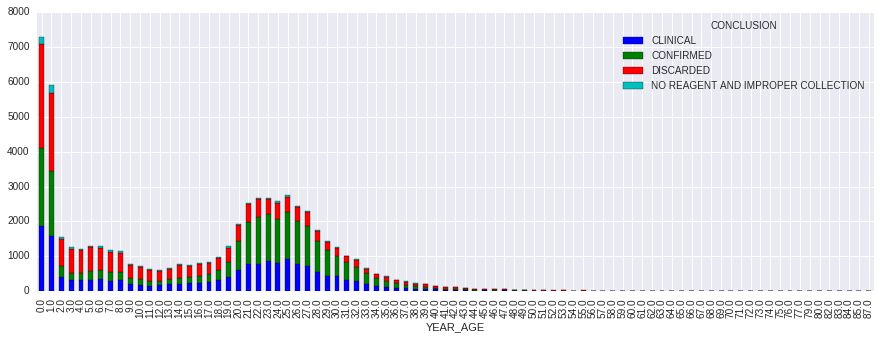

In [11]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

### Vaccination Data

In [12]:
vaccination_data = pd.read_csv('data/BrazilVaxRecords.csv', index_col=0)
vaccination_data.head()

,BIRTHS,VAX,POP,SIA
YEAR,,,,
1980,3896442,0.57,121740438,0
1981,3933136,0.73,124610790,0
1982,3952137,0.66,127525420,0
1983,3952735,0.68,130455659,0
1984,3935224,0.73,133364277,0


In [13]:
vax_97 = np.r_[[0]*(1979-1921+1), vaccination_data.VAX[:17]]
n = len(vax_97)
FOI_mat = np.resize((1 - vax_97*0.9), (n,n)).T

In [14]:
vacc_susc = (1 - vax_97*0.9)[::-1]
vacc_susc[0] = 0.5

In [15]:
sia_susc = np.ones(len(vax_97))
birth_year = np.arange(1922, 1998)[::-1]
by_mask = (birth_year > 1983) & (birth_year < 1992)
sia_susc[by_mask] *= 0.2

## Stochastic Disease Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple SIR disease model, which will be fit using MCMC.

This model fits the series of 2-week infection totals in each district $i$ as a set of Poisson models:

\\[Pr(I(t)_{i} | \lambda(t)_i) = \text{Poisson}(\lambda(t)_i) \\]

Where the outbreak intensity is modeled as:

\\[\lambda(t)_i = \beta [I^{(w)}(t-1)_i]^{\alpha} S(t-1)_i\\]

\\[\alpha \sim \text{Exp}(1)\\]

We will assume here that the transmission rate is constant over time (and across districts):

\\[\beta \sim \text{Gamma}(1, 0.1)\\]

To account for the influence of infected individuals from neighboring districts on new infections, the outbreak intensity was modeled using a spatial-weighted average of infecteds across districts, where populations were weighted as an exponential function of the distance between district centroids:

\\[w_{d} = \text{exp}(-\theta d)\\]

\\[\theta \sim \text{Exp}(1)\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. These estimates are then plugged into the model in place of the clinically-confirmed cases.

We specified a structured confirmation model to retrospectively determine the age group-specific probabilities of lab confirmation for measles, conditional on clinical diagnosis. Individual lab confirmation events $c_i$ were modeled as Bernoulli random variables, with the probability of confirmation being allowed to vary by age group:

$$c_i \sim \text{Bernoulli}(p_{a(i)})$$

where $a(i)$ denotes the appropriate age group for the individual indexed by i. There were 16 age groups, the first 15 of which were 5-year age intervals $[0,5), [5, 10), \ldots , [70, 75)$, with the 16th interval including all individuals 75 years and older.

Since the age interval choices were arbitrary, and the confirmation probabilities of adjacent groups likely correlated, we modeled the correlation structure directly, using a multivariate logit-normal model. Specifically, we allowed first-order autocorrelation among the age groups, whereby the variance-covariance matrix retained a tridiagonal structure. 

$$\begin{aligned}
\Sigma = \left[{
\begin{array}{c}
  {\sigma^2} & {\sigma^2 \rho} & 0& \ldots & {0} & {0}  \\
  {\sigma^2 \rho} & {\sigma^2} &  \sigma^2 \rho & \ldots & {0}  & {0} \\
  {0} & \sigma^2 \rho & {\sigma^2} & \ldots & {0} & {0} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {0} & {0} & 0 & \ldots &  {\sigma^2} & \sigma^2 \rho  \\
{0} & {0} & 0 & \ldots & \sigma^2 \rho &  {\sigma^2} 
\end{array}
}\right]
\end{aligned}$$

From this, the confirmation probabilities were specified as multivariate normal on the inverse-logit scale.

$$ \text{logit}(p_a) = \{a\} \sim N(\mu, \Sigma)$$

Priors for the confirmation sub-model were specified by:

$$\begin{aligned}
\mu_i &\sim N(0, 100) \\
\sigma &\sim \text{HalfCauchy}(25) \\
\rho &\sim U(-1, 1)
\end{aligned}$$

Age classes are defined in 5-year intervals.

In [16]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.YEAR_AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [17]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract confirmed and clinical subset, with no missing county information.

In [18]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.COUNTY.notnull()].copy()

In [19]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
confirmed = (lab_subset.CONCLUSION=='CONFIRMED').values

In [20]:
clinic_subset = measles_data[CLINICAL & measles_data.COUNTY.notnull()].copy()

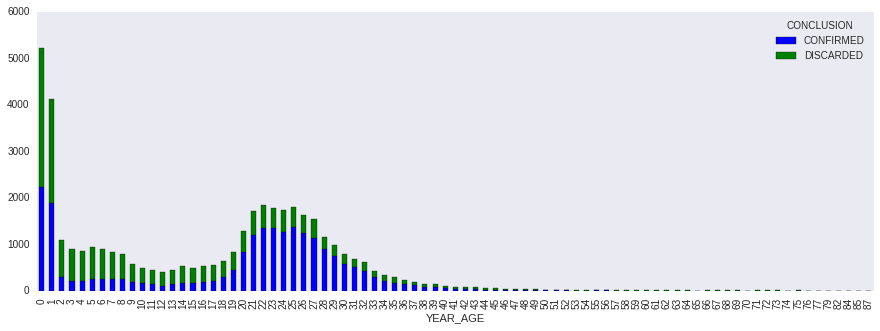

In [21]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [22]:
lab_subset.shape

(41547, 15)

Proportion of lab-confirmed cases older than 20 years

In [23]:
(measles_data[CONFIRMED].YEAR_AGE>20).mean()

0.60257048468117846

In [24]:
age_classes

[0, 5, 10, 15, 20, 25, 30, 35, 40, 100]

In [25]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])
age_groups = age_group.categories
age_groups

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [26]:
age_group.categories

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [27]:
age_slice_endpoints = [g[1:-1].split(',') for g in age_groups]
age_slices = [slice(int(i[0]), int(i[1])) for i in age_slice_endpoints]

In [28]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [29]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [30]:
excludes = ['BOM RETIRO']

In [31]:
N = sp_pop.drop(excludes).ix[unique_districts].sum().drop('Total')

In [32]:
N_age = N.iloc[:8]
N_age.index = age_groups[:-1]
N_age[age_groups[-1]] = N.iloc[8:].sum()
N_age

[0, 5)        844130
[5, 10)       830880
[10, 15)      858750
[15, 20)      904972
[20, 25)      945244
[25, 30)      902086
[30, 35)      835888
[35, 40)      764605
[40, 100)    2841133
dtype: float64

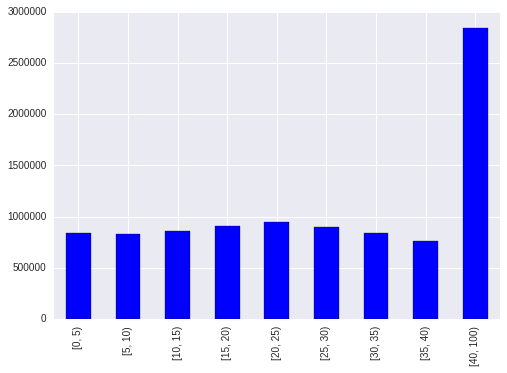

In [33]:
N_age.plot(kind='bar')


Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [34]:
# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = (confirmed_data.groupby(['ONSET', 'AGE_GROUP'])
                    .size()
                    .unstack()
                    .reindex(dates_index)
                    .fillna(0)
                    .sum())

all_confirmed_cases = (confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                       .fillna(0).values.astype(int))

In [35]:
confirmed_counts_2w = (confirmed_data
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W', how='sum'))

In [36]:
# All clinical cases, by district
clinical_counts = (clinic_subset.groupby(['ONSET', 'AGE_GROUP'])
                   .size()
                   .unstack()
                   .reindex(dates_index)
                   .fillna(0)
                   .sum())

all_clinical_cases = (clinical_counts.reindex_axis(measles_data['AGE_GROUP'].unique())
                      .fillna(0).values.astype(int))

In [37]:
clinical_counts_2w = (clinic_subset
                        .groupby(['ONSET', 'AGE_GROUP'])
                        .size()
                        .unstack()
                        .reindex(dates_index)
                        .fillna(0)
                        .resample('2W', how='sum'))

In [38]:
confirmed_counts_2w

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,0,0,0,0,1,0,0,0,0
1997-01-19,0,1,0,0,3,4,0,0,0
1997-02-02,4,1,0,0,2,1,0,0,0
1997-02-16,4,0,0,0,2,1,1,0,0
1997-03-02,9,0,0,2,4,5,1,0,1
1997-03-16,13,2,1,3,12,17,4,0,0
1997-03-30,17,2,2,3,6,5,1,0,0
1997-04-13,18,3,0,1,7,10,3,1,0
1997-04-27,17,3,4,5,23,10,4,0,1


In [39]:
# Ensure the age groups are ordered
clinical_obs = clinical_counts_2w #.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            #axis=1).fillna(0).values.astype(int)
confirmed_obs = confirmed_counts_2w #.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            #axis=1).fillna(0).values.astype(int)

In [40]:
clinical_obs

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,3,1,1,0,0,0,0,0,0
1997-01-19,30,3,1,1,1,3,2,1,0
1997-02-02,22,4,0,2,1,1,1,0,1
1997-02-16,21,2,2,2,2,1,1,0,2
1997-03-02,24,5,2,5,2,2,2,1,0
1997-03-16,39,11,4,10,7,2,3,0,2
1997-03-30,33,5,2,3,3,1,0,1,1
1997-04-13,24,3,1,4,6,3,1,0,2
1997-04-27,31,5,2,4,5,6,2,2,0


In [41]:
confirmed_obs

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,0,0,0,0,1,0,0,0,0
1997-01-19,0,1,0,0,3,4,0,0,0
1997-02-02,4,1,0,0,2,1,0,0,0
1997-02-16,4,0,0,0,2,1,1,0,0
1997-03-02,9,0,0,2,4,5,1,0,1
1997-03-16,13,2,1,3,12,17,4,0,0
1997-03-30,17,2,2,3,6,5,1,0,0
1997-04-13,18,3,0,1,7,10,3,1,0
1997-04-27,17,3,4,5,23,10,4,0,1


In [42]:
clinical_obs.max()

AGE_GROUP
[0, 5)       639
[5, 10)      248
[10, 15)     161
[15, 20)     278
[20, 25)     593
[25, 30)     537
[30, 35)     217
[35, 40)      83
[40, 100)     54
dtype: float64

In [43]:
clinical_obs.sum()

AGE_GROUP
[0, 5)       4268
[5, 10)      1398
[10, 15)      882
[15, 20)     1414
[20, 25)     3678
[25, 30)     3278
[30, 35)     1344
[35, 40)      396
[40, 100)     311
dtype: float64

Check shape of data frame

- 28 bi-monthly intervals, 9 age groups

In [44]:
assert clinical_obs.shape == (28, len(age_groups))

In [45]:
obs_date = '1997-06-15'
obs_index = clinical_counts_2w.index <= obs_date
clinical_obs_t = clinical_obs[obs_index].astype(int)
confirmed_obs_t = confirmed_obs[obs_index].astype(int)

In [46]:
clinical_obs_t

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
ONSET,,,,,,,,,
1997-01-05,3,1,1,0,0,0,0,0,0
1997-01-19,30,3,1,1,1,3,2,1,0
1997-02-02,22,4,0,2,1,1,1,0,1
1997-02-16,21,2,2,2,2,1,1,0,2
1997-03-02,24,5,2,5,2,2,2,1,0
1997-03-16,39,11,4,10,7,2,3,0,2
1997-03-30,33,5,2,3,3,1,0,1,1
1997-04-13,24,3,1,4,6,3,1,0,2
1997-04-27,31,5,2,4,5,6,2,2,0


In [47]:
obs_index = clinical_counts_2w.index <= obs_date
confirmed_obs_t = confirmed_obs[obs_index].values.astype(int)
clinical_obs_t = clinical_obs[obs_index].values.astype(int)

In [48]:
from pymc import MCMC, Matplot, AdaptiveMetropolis, MAP
from pymc import (Uniform, DiscreteUniform, Beta, Binomial, Normal, 
                  CompletedDirichlet,
                  Poisson, NegativeBinomial, negative_binomial_like, poisson_like,
                  Lognormal, Exponential, binomial_like,
                  TruncatedNormal, Binomial, Gamma, HalfCauchy, normal_like,
                  MvNormalCov, Bernoulli, Uninformative, 
                  Multinomial, rmultinomial, rbinomial,
                  Dirichlet, multinomial_like)
from pymc import (Lambda, observed, invlogit, deterministic, potential, stochastic,)

def measles_model(obs_date, confirmation=True, migrant=False):
    
    ### Confirmation sub-model
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
        sig = HalfCauchy('sig', 0, 25, value=1)
        var = sig**2
        cor = Uniform('cor', -1, 1, value=0)

        # Build variance-covariance matrix with first-order correlation 
        # among age classes
        @deterministic
        def Sigma(var=var, cor=cor):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*var*cor
            return I + E + E.T

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, 
                        value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

        @deterministic(trace=False)
        def p_confirm(beta=beta_age):
            return invlogit(beta[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=confirmed, 
                                observed=True)


    '''
    Truncate data at observation period
    '''
    obs_index = clinical_counts_2w.index <= obs_date
    confirmed_obs_t = confirmed_obs[obs_index].values.astype(int)
    clinical_obs_t = clinical_obs[obs_index].values.astype(int)
                        
    n_periods, n_age_groups = confirmed_obs_t.shape

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = obs_index.sum() - 1
    
    if confirmation:
        
        @stochastic(dtype=int)
        def clinical_cases(value=(clinical_obs_t*0.5).astype(int), 
                            n=clinical_obs_t, p=p_age):
            # Binomial confirmation process
            return np.sum([binomial_like(xi, ni, p) for xi,ni in zip(value,n)])
        I = Lambda('I', lambda clinical=clinical_cases: 
                           clinical + confirmed_obs_t.astype(int))

        assert I.value.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I.value, 0)/ float(I.value.sum())
        
    else:
        
        I = confirmed_obs_t + clinical_obs_t

        assert I.shape == (t_obs +1, n_age_groups)
        
        age_dist_init = np.sum(I, 0) / float(I.sum())
        
    
    # Calcuate age distribution from observed distribution of infecteds to date
    _age_dist = Dirichlet('_age_dist', np.ones(n_age_groups), 
                         value=age_dist_init[:-1]/age_dist_init.sum())
    age_dist = CompletedDirichlet('age_dist', _age_dist)
    @potential
    def age_dist_like(p=age_dist, I=I):
        return multinomial_like(I.sum(0), I.sum(), p)


    # Transmission parameter
    beta = HalfCauchy('beta', 0, 25, value=1) #[1]*n_age_groups) 
    decay = Beta('decay', 1, 5, value=0.9)

    @deterministic
    def B(b=beta, d=decay):
        b = np.ones(n_age_groups)*b
        B = b*np.eye(n_age_groups)
        for i in range(1, n_age_groups):
            B += np.diag(np.ones(n_age_groups-i)*b[i:]*d**i, k=-i) 
            B += np.diag(np.ones(n_age_groups-i)*b[:-i]*d**i, k=i)
        return B

    # Downsample annual series to observed age groups
    downsample = lambda x: np.array([x[s].mean() for s in age_slices])

    @deterministic
    def R0(B=B):
        evs = np.linalg.eigvals(B)
        return max(evs[np.isreal(evs)])


    A = Lambda('A', lambda R0=R0: 75./(R0 - 1))
    lt_sum = downsample(np.tril(FOI_mat).sum(0)[::-1])
    natural_susc = Lambda('natural_susc', lambda A=A: np.exp((-1/A) * lt_sum))
#     natural_susc = Beta('natural_susc', 1, 1, value=[0.02]*n_age_groups)

    @deterministic
    def p_mu(natural_susc=natural_susc): 
        return downsample(sia_susc) * downsample(vacc_susc) * natural_susc
    
    p_sigma = Uniform('p_sigma', 0, 100)
    
    a = Lambda('a', lambda mu=p_mu, sigma=p_sigma: mu*sigma)
    b = Lambda('b', lambda mu=p_mu, sigma=p_sigma: (1-mu)*sigma)
    
    p_susceptible = Beta('p_susceptible', a, b, value=p_mu.value)

    # Estimated total initial susceptibles
    S_0 = Binomial('S_0', n=N_age.values.astype(int), p=p_susceptible)
    
    if migrant:
    
        # Data augmentation for migrant susceptibles
        N_migrant = DiscreteUniform('N_migrant', 0, 15000, value=10000)
        mu_age = Uniform('mu_age', 15, 35, value=25)
        sd_age = Uniform('sd_age', 1, 10, value=5)
        M_age = Normal('M_age', mu_age, sd_age**-2, size=15000)

        @deterministic
        def M_0(M=M_age, N=N_migrant):
            # Take first N augmented susceptibles
            M_real = M[:N]
            # Drop into age groups
            M_group = pd.cut(M_real, 
                             [0, 5, 10, 15, 20, 25, 30, 35, 40, 100], 
                             right=False)
            return M_group.value_counts().values

        p_migrant = Lambda('p_migrant', lambda M_0=M_0, S_0=S_0: M_0/(M_0 + S_0))

        I_migrant = [Binomial('I_migrant_%i' % i, I[i], p_migrant) 
                             for i in range(t_obs + 1)]

        I_local = Lambda('I_local', 
                lambda I=I, I_m=I_migrant: 
                         np.array([Ii - Imi for Ii,Imi in zip(I,I_m)]))
        S = Lambda('S', lambda I=I, S_0=S_0, M_0=M_0: S_0 + M_0 - I.cumsum(0))
        S_local = Lambda('S_local', lambda I=I_local, S_0=S_0: S_0 - I.cumsum(0))


    else:

        # Remaining susceptibles at each 2-week period
        S = Lambda('S', lambda I=I, S_0=S_0: S_0 - I.cumsum(axis=0))
    
    # Check shape
    assert S.value.shape == (t_obs+1., n_age_groups)

    # Susceptibles at time t, by age
    S_age = Lambda('S_age', lambda S=S: S[-1].astype(int))
    
    # Force of infection
    @deterministic
    def lam(B=B, I=I, S=S): 
        return S * (I.dot(B) / N_age.values)


    # Check shape
    assert lam.value.shape == (t_obs+1, n_age_groups)
    
    # FOI in observation period
    lam_t = Lambda('lam_t', lambda lam=lam: lam[-1])

    # Poisson likelihood for observed cases
    @potential
    def new_cases(I=I, lam=lam):
#         return negative_binomial_like(I[1:].sum(1), lam[:-1], I[:-1].sum(1))
        return poisson_like(I[1:], lam[:-1])
    
    '''
    Vaccination targets
    '''
    
    @deterministic
    def vacc_5(S=S_age):
        # Vaccination of 5 and under
        p = [0.95] + [0]*(n_age_groups - 1)
        return rbinomial(S, p)
    
    # Proportion of susceptibles vaccinated
    pct_5 = Lambda('pct_5', 
                lambda V=vacc_5, S=S_age: V.sum()/S.sum())


    @deterministic
    def vacc_15(S=S_age):
        # Vaccination of 15 and under
        p = [0.95]*3 + [0]*(n_age_groups - 3)
        return rbinomial(S, p)
    
    # Proportion of susceptibles vaccinated
    pct_15 = Lambda('pct_15', 
            lambda V=vacc_15, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_30(S=S_age):
        # Vaccination of 30 and under
        p = [0.95]*6 + [0]*(n_age_groups - 6)
        return rbinomial(S, p)
    
    # Proportion of 30 and under susceptibles vaccinated
    pct_30 = Lambda('pct_30', 
            lambda V=vacc_30, S=S_age: V.sum()/S.sum())
    
    @deterministic
    def vacc_adult(S=S_age):
        # Vaccination of adults under 30 (and young kids)
        p = [0.95, 0, 0, 0, 0.95, 0.95] + [0]*(n_age_groups - 6)
        return rbinomial(S, p)
    
    # Proportion of adults under 30 (and young kids)
    pct_adult = Lambda('pct_adult', 
            lambda V=vacc_adult, S=S_age: V.sum()/S.sum())

    return locals()

Run models for June 15 and July 15 observation points, both with and without clinical confirmation.

In [49]:
n_iterations = 50000
n_burn = 40000
migrant = True

June 15, with lab confirmation

In [50]:
model = measles_model

In [51]:
model_june = MCMC(model('1997-06-15', migrant=migrant))

In [52]:
model_june.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 664.6 sec

July 15, with lab confirmation

In [53]:
model_july = MCMC(model('1997-07-15', migrant=migrant))

In [54]:
model_july.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 686.7 sec

June 15, no lab confirmation

In [55]:
model_june_noconf = MCMC(model('1997-06-15', confirmation=False, migrant=migrant))

In [56]:
model_june_noconf.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 470.8 sec

July 15, no lab confirmation

In [57]:
model_july_noconf = MCMC(model('1997-07-15', confirmation=False, migrant=migrant))

In [58]:
model_july_noconf.sample(n_iterations, n_burn)

 [-----------------100%-----------------] 50000 of 50000 complete in 491.3 sec

## Summary of model output

Estimates of R0 for june and july

Plotting R0


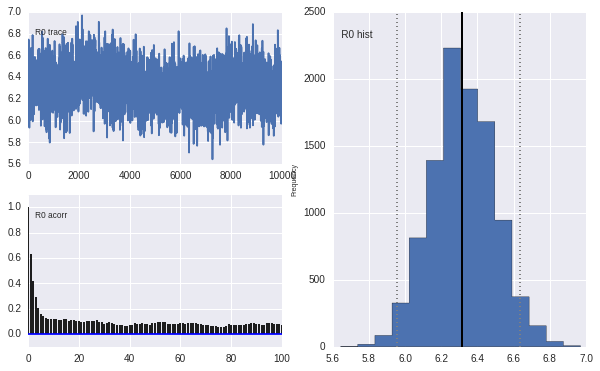

In [59]:
if model_june.R0.value.shape:
    Matplot.summary_plot(model_june.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_june.R0)

Plotting R0


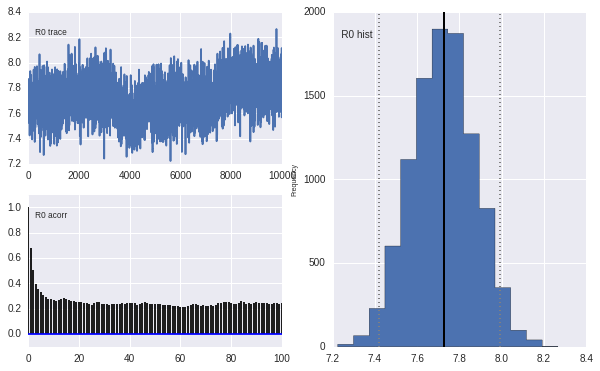

In [60]:
if model_july.beta.shape:
    Matplot.summary_plot(model_july.R0, custom_labels=age_groups)
else:
    Matplot.plot(model_july.R0)

Lab confirmation rates, June model

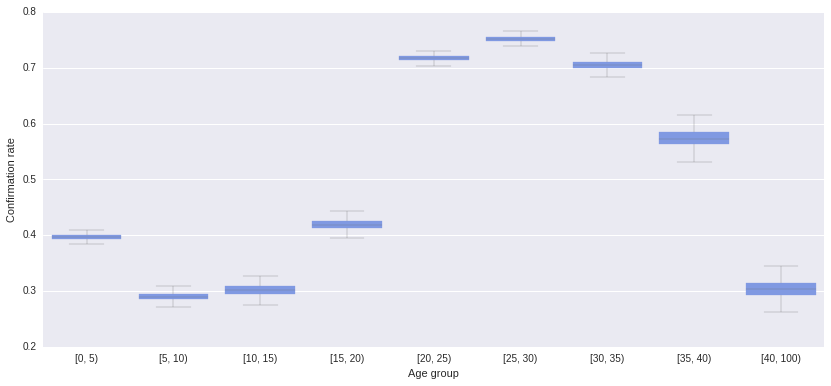

In [61]:
p_age = pd.DataFrame(model_june.p_age.trace(), columns=age_groups)

f, axes = plt.subplots(figsize=(14,6))
sb.boxplot(data=p_age, linewidth=0.3, fliersize=0, ax=axes,
          color=sb.color_palette("coolwarm", 5)[0],
          order=age_group.categories)
axes.set_ylabel('Confirmation rate')
axes.set_xlabel('Age group')

Proportion of population susceptible, June model.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


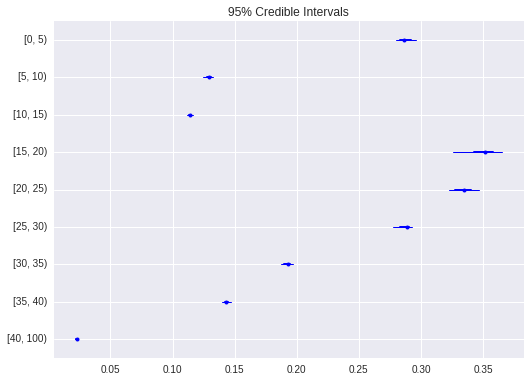

In [62]:
Matplot.summary_plot(model_june.p_susceptible, custom_labels=age_groups)

Proportion of population susceptible, June model with no confirmation correction

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


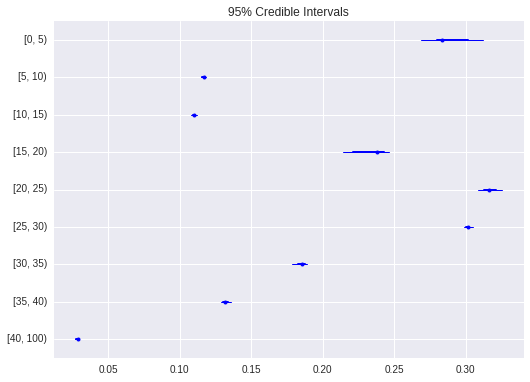

In [63]:
Matplot.summary_plot(model_june_noconf.p_susceptible, custom_labels=age_groups)

Epidemic intensity estimates at June and July, per district.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


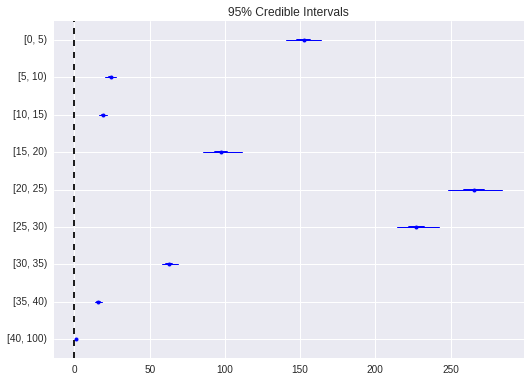

In [64]:
Matplot.summary_plot(model_june.lam_t, custom_labels=age_groups)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


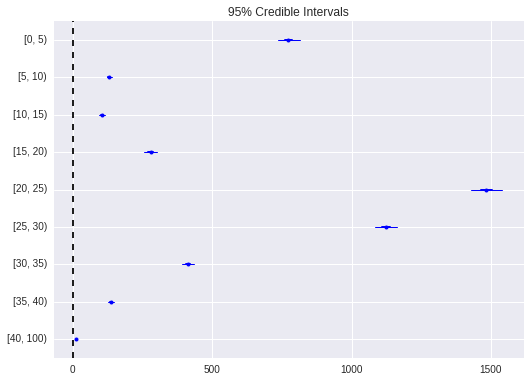

In [65]:
Matplot.summary_plot(model_july.lam_t, custom_labels=age_groups)

Epidemic intensity for lab- versus clinical-confirmation models

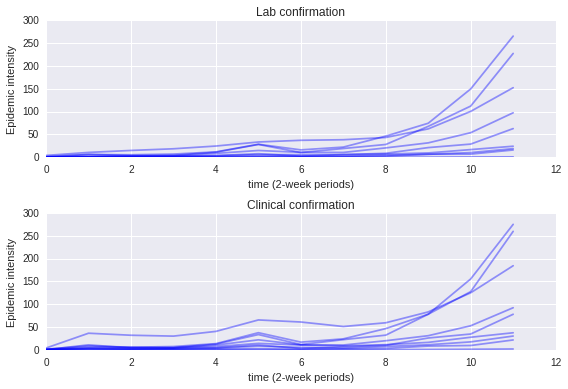

In [66]:
lam_june = model_june.lam.stats()

fig, axes = plt.subplots(2, 1, sharey=True)

axes[0].plot(lam_june['quantiles'][50], 'b-', alpha=0.4)
axes[0].set_ylabel('Epidemic intensity')
axes[0].set_xlabel('time (2-week periods)')
axes[0].set_title('Lab confirmation')

lam_june_noconf = model_june_noconf.lam.stats()

axes[1].plot(lam_june_noconf['quantiles'][50], 'b-', alpha=0.4)
axes[1].set_ylabel('Epidemic intensity')
axes[1].set_xlabel('time (2-week periods)')
axes[1].set_title('Clinical confirmation')

plt.tight_layout()

In [67]:
pd.DataFrame(model_june.S_age.trace().squeeze())

,0,1,2,3,4,5,6,7,8
0,242324,104185,97156,330207,305201,262614,156292,111332,65883
1,242324,104185,97156,330207,305201,262614,156292,111332,65883
2,242134,104103,97052,329784,305578,262358,156145,111450,65961
3,242136,104108,97094,329963,305897,262602,156207,111458,65961
4,242346,104024,97008,329567,305508,262369,156067,111540,66017
5,242131,103938,97089,330877,307523,263875,156684,111509,65926
6,242131,103918,96930,330007,305916,262617,156246,111462,65925
7,242131,103918,96930,330007,305916,262617,156246,111462,65925
8,242131,103919,96929,330002,305923,262614,156247,111462,65925
9,242367,103815,96805,330175,305885,262068,156300,111366,65849


In [68]:
S_age_june = pd.DataFrame(model_june.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june.columns = 'Age', 'Iteration', 'S'
S_age_june['Confirmation'] = 'Lab'

S_age_june_noconf = pd.DataFrame(model_june_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_june_noconf.columns = 'Age', 'Iteration', 'S'
S_age_june_noconf['Confirmation'] = 'Clinical'

S_age_june = pd.concat([S_age_june, S_age_june_noconf], ignore_index=True)

In [69]:
S_age_july = pd.DataFrame(model_july.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july.columns = 'Age', 'Iteration', 'S'
S_age_july['Confirmation'] = 'Lab'

S_age_july_noconf = pd.DataFrame(model_july_noconf.S_age.trace().squeeze(), columns=age_groups).unstack().reset_index()
S_age_july_noconf.columns = 'Age', 'Iteration', 'S'
S_age_july_noconf['Confirmation'] = 'Clinical'

S_age_july = pd.concat([S_age_july, S_age_july_noconf], ignore_index=True)

Numbers of suscepibles in each age group, under lab vs clinical confirmation

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


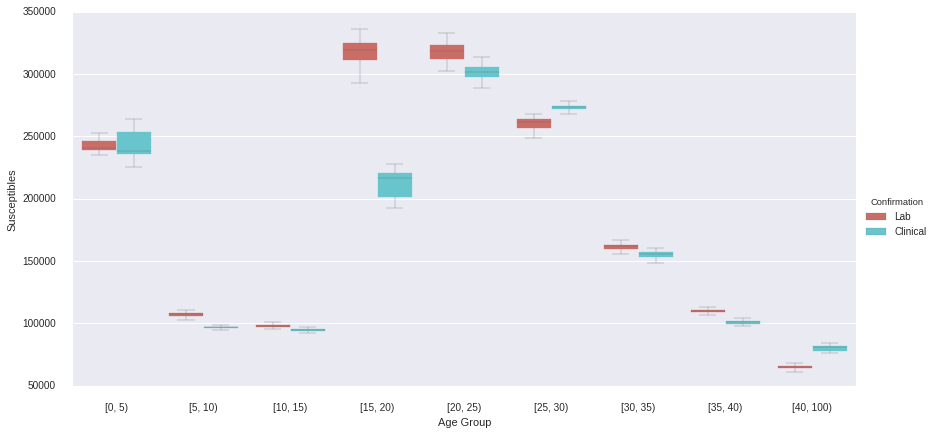

In [70]:
g = sb.factorplot("Age", "S", "Confirmation", S_age_june, kind="box",
                   palette="hls", size=6, aspect=2, linewidth=0.3, fliersize=0, 
                  order=age_group.categories)
g.despine(offset=10, trim=True)
g.set_axis_labels("Age Group", "Susceptibles");

### Vaccination coverage by strategy

In [71]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.137            0.002            0.0              [ 0.133  0.142]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.134            0.135           0.136          0.139         0.142
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.253            0.003            0.0              [ 0.248  0.26 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.249            0.251           0.252          0.255         0.261
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [72]:
june_coverage = pd.DataFrame({name: model_june.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_coverage['Month'] = 'June'
june_coverage['Confirmation'] = 'Lab'

In [73]:
june_noconf_coverage = pd.DataFrame({name: model_june_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
june_noconf_coverage['Month'] = 'June'
june_noconf_coverage['Confirmation'] = 'Clinical'

july_coverage = pd.DataFrame({name: model_july.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_coverage['Month'] = 'July'
july_coverage['Confirmation'] = 'Lab'

july_noconf_coverage = pd.DataFrame({name: model_july_noconf.trace(name)[:] for name in ['pct_5', 'pct_15', 'pct_30', 'pct_adult']})
july_noconf_coverage['Month'] = 'July'
july_noconf_coverage['Confirmation'] = 'Clinical'

In [74]:
coverage = pd.concat([june_coverage, june_noconf_coverage, july_coverage, july_noconf_coverage], 
                     ignore_index=True)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


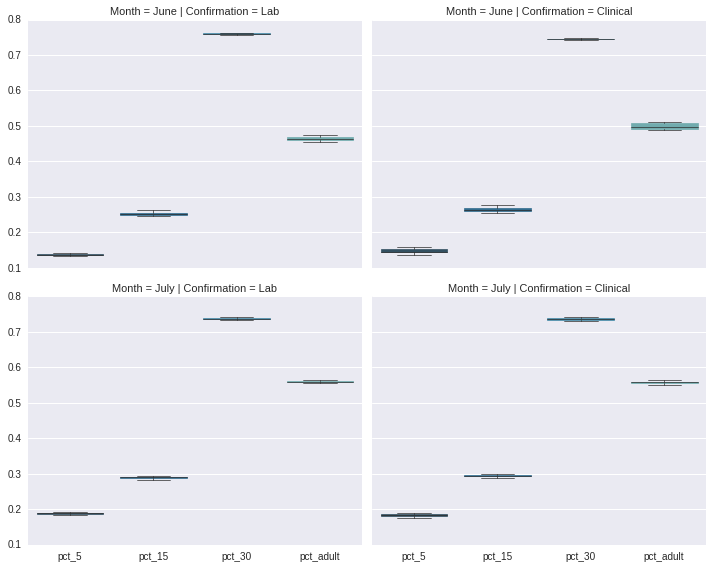

In [75]:
sb.factorplot(row="Month", col="Confirmation", data=coverage, kind='box',
              row_order=['June', 'July'],
              order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'],
               palette="YlGnBu_d", linewidth=0.7, fliersize=0, aspect=1.25).despine(left=True)

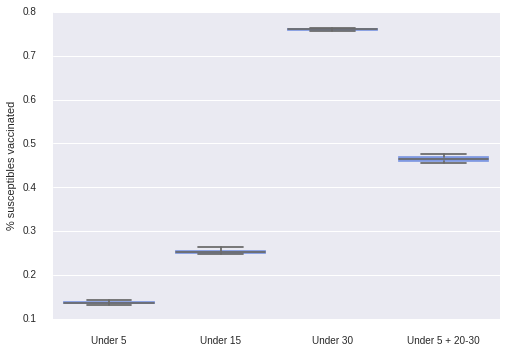

In [76]:
axes = sb.boxplot(data=june_coverage, order=['pct_5', 'pct_15', 'pct_30', 'pct_adult'], 
                  color=sb.color_palette("coolwarm", 5)[0])
axes.set_xticklabels(['Under 5', 'Under 15', 'Under 30', 'Under 5 + 20-30'])
axes.set_ylabel('% susceptibles vaccinated')
sb.despine(offset=10, trim=True)

In [77]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.148            0.006            0.001            [ 0.139  0.159]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.139            0.144           0.146          0.154         0.159
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.265            0.006            0.001            [ 0.255  0.276]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.256            0.26            0.263          0.27          0.276
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [78]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.188            0.002            0.0              [ 0.185  0.191]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.185            0.187           0.189          0.19          0.191
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.29             0.003            0.0              [ 0.285  0.293]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.284            0.288           0.29           0.292         0.293
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [79]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.184            0.003            0.0              [ 0.177  0.189]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.177            0.182           0.185          0.187         0.189
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.295            0.002            0.0              [ 0.291  0.3  ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.29             0.294           0.295          0.297         0.299
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------